In [293]:
import pandas as pd
import plotly.offline as py
import matplotlib.pyplot as mlt
import plotly.express as px
import seaborn as sns
py.init_notebook_mode(connected=True)
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

In [294]:
d1=pd.read_csv('ball_by_ball.csv')

In [295]:
d1.head()

,ball,batsman,bowler,extras-byes,extras-legbyes,extras-noballs,extras-penalty,extras-wides,fielders,file_name,...,non_striker,o_team,over,runs-batsman,runs-extras,runs-non_boundary,runs-total,team,wicket-kind,wicket-player_out
0,1,RV Uthappa,IK Pathan,NaN,NaN,NaN,NaN,NaN,NaN,598067.yaml,...,AJ Finch,Delhi Daredevils,0,0,0,NaN,0,Pune Warriors,NaN,NaN
1,2,RV Uthappa,IK Pathan,NaN,NaN,NaN,NaN,NaN,NaN,598067.yaml,...,AJ Finch,Delhi Daredevils,0,2,0,NaN,2,Pune Warriors,NaN,NaN
2,3,RV Uthappa,IK Pathan,NaN,NaN,NaN,NaN,NaN,NaN,598067.yaml,...,AJ Finch,Delhi Daredevils,0,4,0,NaN,4,Pune Warriors,NaN,NaN
3,4,RV Uthappa,IK Pathan,NaN,NaN,NaN,NaN,NaN,NaN,598067.yaml,...,AJ Finch,Delhi Daredevils,0,0,0,NaN,0,Pune Warriors,NaN,NaN
4,5,RV Uthappa,IK Pathan,NaN,NaN,NaN,NaN,NaN,NaN,598067.yaml,...,AJ Finch,Delhi Daredevils,0,1,0,NaN,1,Pune Warriors,NaN,NaN


In [296]:
d1.shape

(178129, 23)

In [297]:
d1.isna().sum()

ball                      0
batsman                   0
bowler                    0
extras-byes          177653
extras-legbyes       175203
extras-noballs       177418
extras-penalty       178127
extras-wides         172748
fielders             171817
file_name                 0
innings                   0
is_wicket                 0
match_id                  0
non_striker               0
o_team                    0
over                      0
runs-batsman              0
runs-extras               0
runs-non_boundary    178115
runs-total                0
team                      0
wicket-kind          169338
wicket-player_out    169338
dtype: int64

# Exoploratory Data Analysis

### Identifying the favorite bowlers and non favorite bowlers for a batsman. Considering strike rate, wickets taken by the bowlers to find the favorite and non favorite bowlers 

In [298]:
def rank_of_bowlers_for_batsman(name):
    
    #Filtering the batsman
    dummy=d1[d1['batsman']==name]
    dummy.rename({'ball':'ball1'},inplace=True)
    dummy['ball']=1
    #Considering wicket_kind counts(total_wickets count) taken by the bowler for the resspective batsman
    wicket_kinds = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]  #since run-out is not creditted to the bowler
    ct=dummy[dummy["wicket-kind"].isin(wicket_kinds)]
    ct=(pd.DataFrame(ct['bowler'].value_counts()).reset_index()).rename(columns={'bowler':'Number of wickets taken','index':'bowler'})
    ct.reset_index(inplace=True)
    ct.drop('index',axis=1,inplace=True)
    all_bowlers=list(d1['bowler'].unique())
    ctt=pd.DataFrame(dummy[~dummy["bowler"].isin(list(ct['bowler'].unique()))].reset_index()['bowler'].unique(),columns=['bowler'])
    ctt['Number of wickets taken']=0
    Wickets_data=pd.concat([ct,ctt[['bowler','Number of wickets taken']]],axis=0)
    
    
    #Considering strike rate from score and the balls played by the batsman
    x=pd.pivot_table(dummy,index=['bowler'],values=['ball','runs-total'],aggfunc=['sum'])
    x=x.droplevel(axis=1, level=0).reset_index()
    x['strike_rate']=(x['runs-total']/x['ball'])*100
    
    
    #Merging wickets_data taken by the bowlwr & strike rate data by the batsman
    data=x.merge(Wickets_data, how='inner', on='bowler')
    data.sort_values(by=['strike_rate','Number of wickets taken'],inplace=True,ascending=[False,False])
    data.reset_index(inplace=True)
    data.drop(columns='index',axis=1,inplace=True)
    print('\n')
    print("Printing first five rows of the formulated data using balls, runs, wickets to get the favarite bowlers :")
    display(data.head())
    
    #Plotting the out using plotly
    plot_data=data.iloc[:20]
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Bar(x=plot_data['bowler'], y=plot_data['strike_rate'], name="Strike_rate with respective bowler for "+name),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=plot_data['bowler'], y=plot_data['Number of wickets taken'], name="Number of wickets taken by the bowler to "+name),
        secondary_y=True,
    )
    # Add figure title
    fig.update_layout(
        title_text="Top Twenty favorite bowlwers for "+str(name)+" formulated using strike rate & the wicket's taken by the bowler "
    )
    
    fig.show()
    #For Top Non-favorite bowlwers
    data.sort_values(by=['strike_rate','Number of wickets taken'],inplace=True,ascending=[True,True])
    plot_data=data.iloc[:20]
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Bar(x=plot_data['bowler'], y=plot_data['strike_rate'], name="Strike_rate with respective bowler for "+name),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(x=plot_data['bowler'], y=plot_data['Number of wickets taken'], name="Number of wickets taken by the bowler to "+name),
        secondary_y=True,
    )
    # Add figure title
    fig.update_layout(
        title_text="Top Twenty Non-favorite bowlwers for "+str(name)+" formulated using strike rate & the wicket's taken by the bowler "
    )
    fig.show()
    
    
    
    
    #Extras Distribution and Types Of Wickets for
    dummy=d1[d1['batsman']=='RV Uthappa']
    extras=['wide_runs','bye_runs','legbye_runs','noball_runs']
    sizes=[5161,680,3056,612]

    dismiss=["run out","bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]
    ct=dummy[dummy["wicket-kind"].isin(dismiss)]
    bx=ct['wicket-kind'].value_counts()[:10]


    fig = {
        
      "data": [
        {
          "values": sizes,
          "labels": extras,
          "domain": {"x": [0, .48]},
          "name": "Extra's",
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        },     
        {
          "values": bx.values ,
          "labels": bx.index,
          "textposition":"inside",
          "domain": {"x": [.54, 1]},
          "name": "Wickets",
          "hoverinfo":"label+percent+name",
          "hole": .4,
          "type": "pie"
        }],
      "layout": {
            "title":"Extras Distribution and Types Of Wickets for "+name,
            "annotations": [
                {
                    "font": {
                        "size": 15
                    },
                    "showarrow": False,
                    "text": "EXTRA'S",
                    "x": 0.18,
                    "y": 0.5
                },
                {
                    "font": {
                        "size": 15
                    },
                    "showarrow": False,
                    "text": "WICKETS",
                    "x": 0.85,
                    "y": 0.5
                }
            ]
        }
    }
    py.iplot(fig, filename='donut')
    
    return data

In [299]:
rank=rank_of_bowlers_for_batsman('RV Uthappa')



Printing first five rows of the formulated data using balls, runs, wickets to get the favarite bowlers :


,bowler,ball,runs-total,strike_rate,Number of wickets taken
0,AC Voges,1,4,400.000000,0
1,B Geeves,2,8,400.000000,0
2,AB McDonald,2,7,350.000000,0
3,B Lee,7,24,342.857143,0
4,S Sreesanth,20,58,290.000000,0


### Identifying the best batsman from the two teams to send a batsman for a super over. Considering the strike rate, boundary rate to choose the right batsman. Super over historical data is also taken into consideration & recommendations for the batsman are also given from super over's data

In [332]:
def tpo_five_bastamn_for_super_over(team,opposite_team,i):
    if i==1:
        filtered=d1[(d1['team']==team)]
        team1=team
    else:
        filtered=d1[(d1['team']==opposite_team)]
        team1=opposite_team
    
    filtered.rename({'ball':'ball1'},inplace=True)
    filtered['ball']=1
    filtered=pd.pivot_table(filtered, index = ['batsman'], values = ['ball', 'runs-total','runs-batsman'],aggfunc ={'ball':sum,'runs-total':sum, 'runs-batsman':lambda x: (x>=4).sum()})
    filtered.rename(columns={'runs-batsman':"Total Boundaries"},inplace=True)
    filtered['strike_rate']=(filtered['runs-total']/filtered['ball'])*100
    filtered.reset_index(inplace=True)
    filtered.sort_values(by=['Total Boundaries','strike_rate',],inplace=True,ascending=[False,False])
    filtered.reset_index(inplace=True)
    filtered.drop(columns='index',axis=1,inplace=True)
    
    print('\n')
    display(filtered.head())
    
    #Considering historical super over data 
    super_over_teams=['Kolkata Knight Riders','Rajasthan Royals','Royal Challengers Bangalore','Sunrisers Hyderabad','Kings XI Punjab','Mumbai Indians','Gujarat Lions Super Over','Delhi Capitals','Delhi Daredevils','Chennai Super Kings']
    if team1 in super_over_teams:
        name=team1+' Super Over'
        superover=d1[d1['innings']==name]
        super_O=superover[['runs-total','batsman']].reset_index()
        super_O=superover['runs-total'].groupby(superover['batsman']).agg(['sum']).reset_index()
        super_O.sort_values(by=['sum'],inplace=True,ascending=[False])
        fig = px.bar(super_O, y='sum', x='batsman',title="Recommendation from historic super_over data")
        fig.show()
        
    else:
        print('No recommendations from previous super overs data')
        
    #Plotting the out using plotly
    plot_data=filtered.iloc[:5]
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    # Add traces
    fig.add_trace(
        go.Bar(x=plot_data['batsman'], y=plot_data['strike_rate'], name="Strike_rate with respective bowler" ),
        secondary_y=False
    )
    fig.add_trace(
        go.Scatter(x=plot_data['batsman'], y=plot_data['Total Boundaries'], name="Number of boundaries hit by the batsman (4 or 6) "),
        secondary_y=True,
    )
    # Add figure title
    fig.update_layout(
        title_text="Top Five batsman of the "+team1+" chosen for the super over."
    )

    fig.show()

In [333]:
for i in range(2):
    tpo_five_bastamn_for_super_over('Kolkata Knight Riders','Rajasthan Royals',i)

,batsman,ball,Total Boundaries,runs-total,strike_rate
0,AM Rahane,2350,355,2927,124.553191
1,SR Watson,1734,347,2489,143.540946
2,R Dravid,1177,185,1346,114.358539
3,SV Samson,1188,180,1579,132.912458
4,YK Pathan,655,153,1069,163.206107


,batsman,ball,Total Boundaries,runs-total,strike_rate
0,G Gambhir,2533,398,3223,127.240426
1,RV Uthappa,1841,343,2564,139.272135
2,YK Pathan,1421,236,1997,140.534835
3,AD Russell,761,211,1424,187.122208
4,CA Lynn,928,190,1327,142.995690


# Score Distribution For Teams by Innings

In [ ]:
mlt.subplots(figsize=(12,6))
xyz=d1.groupby(['match_id','innings','team'])['runs-total'].sum().reset_index()
xyz.drop('match_id',axis=1,inplace=True)
xyz=xyz.sort_values(by=['team','runs-total'],ascending=True)
score_1_inning=xyz[xyz['innings']=='1st innings']
score_2_inning=xyz[xyz['innings']=='2nd innings']
sns.boxplot(x='team',y='runs-total',data=score_1_inning).set_title('1st Innings')
mlt.xticks(rotation=45)
mlt.show()
sns.boxplot(x='team',y='runs-total',data=score_2_inning).set_title('2nd Innings')
fig=mlt.gcf()
mlt.xticks(rotation=45)
fig.set_size_inches(12,6)

# Observation

### According to Graph 1 the batting by CSK in innings 1 looks to be the best. Graph 2 also conveys the same story. In Graph 2 we see a point near 0 which may seem to be outlier. But it is so because the match was disrupted.

# Top Batsman's with 1's, 2's, 3's, 4's

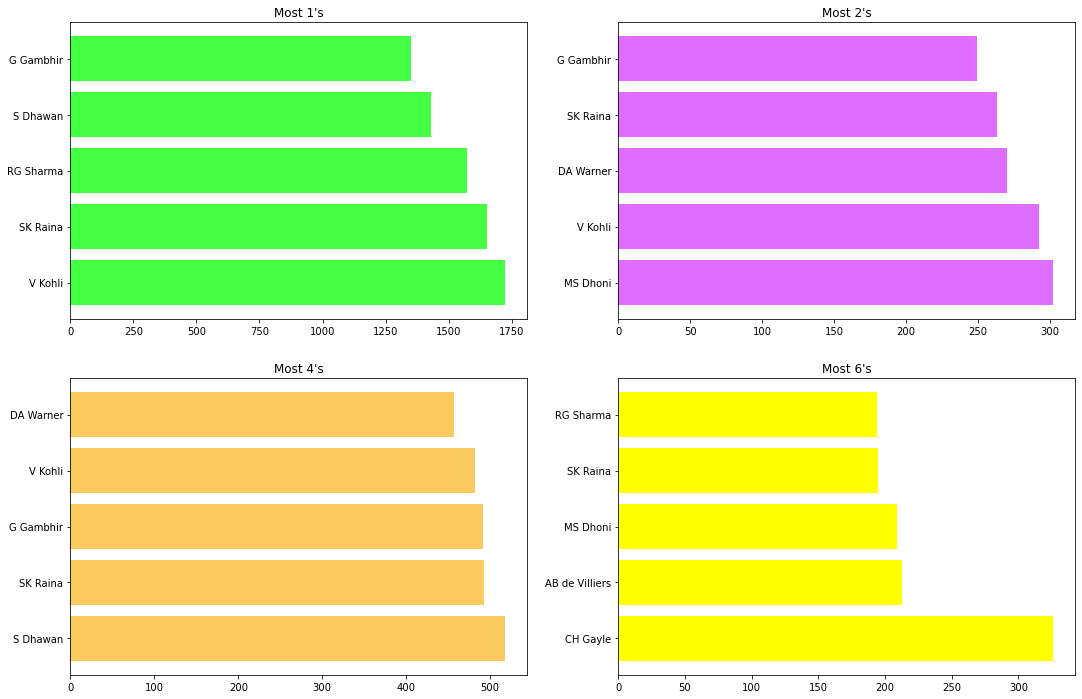

In [188]:
toppers=d1.groupby(['batsman','runs-batsman'])['runs-total'].count().reset_index()
toppers=toppers.pivot('batsman','runs-batsman','runs-total')
fig,ax=mlt.subplots(2,2,figsize=(18,12))
toppers[1].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[0,0],color='#45ff45',width=0.8)
ax[0,0].set_title("Most 1's")
ax[0,0].set_ylabel('')
toppers[2].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[0,1],color='#df6dfd',width=0.8)
ax[0,1].set_title("Most 2's")
ax[0,1].set_ylabel('')
toppers[4].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[1,0],color='#fbca5f',width=0.8)
ax[1,0].set_title("Most 4's")
ax[1,0].set_ylabel('')
toppers[6].sort_values(ascending=False)[:5].plot(kind='barh',ax=ax[1,1],color='#ffff00',width=0.8)
ax[1,1].set_title("Most 6's")
ax[1,1].set_ylabel('')
mlt.show()

# Observations:

Kohli has scored the maximum 1's
Dhoni has the maximum 2's . Those Strong Legs :p
Dhawan has the maximum 4's.
C Gayle has the maximum 6's and he leads by a big margin.

# Top Individual Scores

In [207]:
top_scores = d1.groupby(["match_id", "batsman","team"])["runs-batsman"].sum().reset_index()
top_scores=top_scores[top_scores['runs-batsman']>100]
top_scores.sort_values('runs-batsman', ascending=0).head(10)
top_scores.nlargest(10,'runs-batsman')

,match_id,batsman,team,runs-batsman
2644,175,CH Gayle,Royal Challengers Bangalore,175
3795,251,BB McCullum,Kolkata Knight Riders,158
6303,421,AB de Villiers,Royal Challengers Bangalore,133
4363,289,AB de Villiers,Royal Challengers Bangalore,129
2131,140,CH Gayle,Royal Challengers Bangalore,128
5151,344,RR Pant,Delhi Daredevils,128
1760,116,M Vijay,Chennai Super Kings,127
3928,261,DA Warner,Sunrisers Hyderabad,126
4858,323,V Sehwag,Kings XI Punjab,122
6909,462,PC Valthaty,Kings XI Punjab,120


# Individual Scores By Top Batsman each Inning

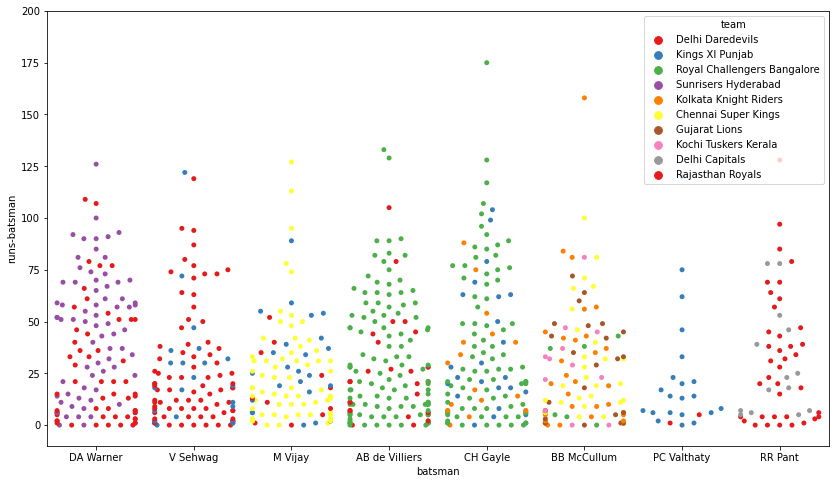

In [205]:
swarm=['CH Gayle', 'BB McCullum', 'AB de Villiers', 'RR Pant', 'M Vijay',
       'DA Warner', 'V Sehwag', 'PC Valthaty']
scores = d1.groupby(["match_id", "batsman","team"])["runs-batsman"].sum().reset_index()
scores=scores[top_scores['batsman'].isin(swarm)]
sns.swarmplot(x='batsman',y='runs-batsman',data=scores,hue='team',palette='Set1')
fig=mlt.gcf()
fig.set_size_inches(14,8)
mlt.ylim(-10,200)
mlt.show()

# Top Bowlers

## Highest Wicket Taker

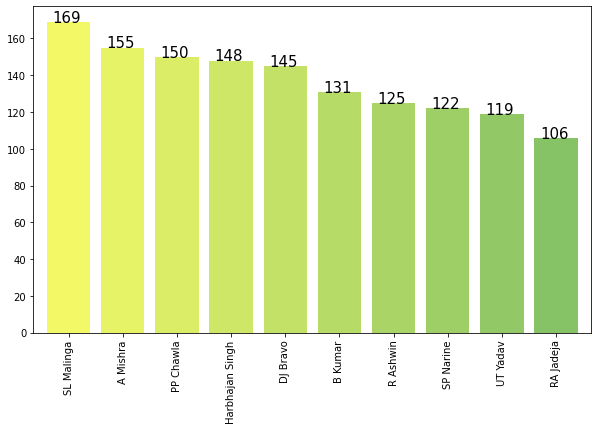

In [197]:
mlt.subplots(figsize=(10,6))
dismissal_kinds = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]  #since run-out is not creditted to the bowler
ct=d1[d1["wicket-kind"].isin(dismissal_kinds)]
ax=ct['bowler'].value_counts()[:10].plot.bar(width=0.8,color=sns.color_palette('summer_r',20))
for p in ax.patches:
    ax.annotate(format(p.get_height()), (p.get_x()+0.10, p.get_height()),fontsize=15)
mlt.show()

# Top 20 Bowlers

In [210]:
bowlers=d1.groupby('bowler').sum().reset_index()
bowl=d1['bowler'].value_counts().reset_index()
bowlers=bowlers.merge(bowl,left_on='bowler',right_on='index',how='left')
bowlers=bowlers[['bowler_x','runs-total','bowler_y']]
bowlers.rename({'bowler_x':'bowler','runs-total':'runs_given','bowler_y':'balls'},axis=1,inplace=True)
bowlers['overs']=(bowlers['balls']//6)
dismissal_kinds = ["bowled", "caught", "lbw", "stumped", "caught and bowled", "hit wicket"]  
ct=d1[d1["wicket-kind"].isin(dismissal_kinds)]
ct=ct['bowler'].value_counts()[:20].reset_index()
bowlers=bowlers.merge(ct,left_on='bowler',right_on='index',how='left').dropna()
bowlers=bowlers[['bowler_x','runs_given','overs','bowler_y']]
bowlers.rename({'bowler_x':'bowler','bowler_y':'wickets'},axis=1,inplace=True)
bowlers['economy']=(bowlers['runs_given']/bowlers['overs'])
bowlers.head()


,bowler,runs_given,overs,wickets,economy
6,A Mishra,3804,520,155.0,7.315385
8,A Nehra,2537,329,106.0,7.711246
55,B Kumar,3191,446,131.0,7.154709
95,DJ Bravo,3646,444,145.0,8.211712
112,DW Steyn,2449,367,96.0,6.673025


In [212]:
trace = go.Scatter(
    y = bowlers['wickets'],
    x = bowlers['bowler'],
    mode='markers',
    marker=dict(
        size= bowlers['wickets'].values,
        color = bowlers['economy'].values,
        colorscale='Viridis',
        showscale=True,
        colorbar = dict(title = 'Economy'),
    ),
    text = bowlers['overs'].values
)
data = [(trace)]

layout= go.Layout(
    autosize= True,
    title= 'Top 20 Wicket Taking Bowlers',
    hovermode= 'closest',
    xaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        title='Bowlers'
    ),
    yaxis=dict(
        title= 'Wickets Taken',
        ticklen= 5,
        gridwidth= 2,
        showgrid=False,
        zeroline=False,
        showline=False
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatterChol')

# Teams with maximum Boundaries

In [337]:
ax=d1[d1['runs-batsman']==6].team.value_counts().reset_index()
ax2=d1[d1['runs-batsman']==4].team.value_counts().reset_index()
ax=ax.merge(ax2,left_on='index',right_on='index',how='left')
ax.rename({'index':'team','team_x':"6's",'team_y':"4's"},axis=1,inplace=True)

trace1 = go.Bar(
    x=ax.team.values, y=ax["6's"],
    name="6's",
    orientation = 'v',
    marker = dict(color = 'rgba(204,12,28, 0.6)',
        line = dict(color = 'rgba(204,12,28, 0.6)',
            width = 3)
    )
)
trace2 = go.Bar(
    x=ax.team.values, y=ax["4's"],
    name="4's",
    orientation = 'v',
    marker = dict(color = 'rgba(9,234,227, 0.6)',
        line = dict(color = 'rgba(9, 227, 227, 1.0)',
            width = 3)
    )
)

data = [trace1, trace2]
layout = go.Layout(
    barmode='stack'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='marker-h-bar')